## Apple Stock Prediction

### 0) Import Modules 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as datetime
import math

import keras
from tensorflow.keras import layers
from keras.utils import np_utils

### 1) Preprocess Data

By taking just teh "AAPL" column we will ignore any signal in date field for now:

In [22]:
raw_DF = pd.read_csv("../data/AAPL_OC_return.csv")
daily_changes = raw_DF["AAPL"].values 

We plot a histogram of the percentage price changes to get a feel for the data:

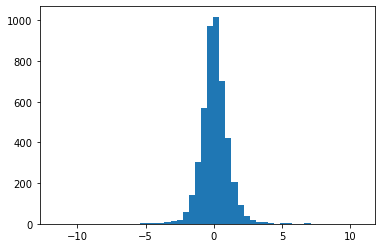

In [23]:
plt.hist(daily_changes, bins=50)
plt.show()

Using a continuous scalar as input to our model may give too many degrees of freedom, so we band the percentage changes:

In [24]:
np.percentile(daily_changes, [1, 10, 25, 50, 75, 90, 99])

array([-2.48075891, -1.05222614, -0.47773935,  0.03416318,  0.60865234,
        1.18524268,  2.57450428])

In [25]:
boundaries = [-2.5, -1, -0.5, 0, 0.5, 1, 2.5]

In [26]:
daily_changes_banded = np.digitize(daily_changes, boundaries)

We will also only be interested if we should short or long AAPL stock, so we create a binary target:

In [27]:
daily_changes_binary = np.digitize(daily_changes, [0])

Check percentage changes were banded correctly for feature and targe:

In [28]:
[('{:.3f}'.format(percent), band, booly) for i, (percent, band, booly) in enumerate(zip(daily_changes, daily_changes_banded, daily_changes_binary)) if i < 10]

[('-1.263', 1, 0),
 ('0.495', 4, 1),
 ('-0.207', 3, 0),
 ('-0.737', 2, 0),
 ('-0.856', 2, 0),
 ('1.377', 6, 1),
 ('0.422', 4, 1),
 ('0.413', 4, 1),
 ('0.320', 4, 1),
 ('0.876', 5, 1)]

In [29]:
def feature_target(N, feature_time_series, target_time_series):
    """
    Create feature-target pairs from a time series for model training.
    
    Parameters
    ----------
    N: int
       The number of days that will be used predict tomorrows stock movement
    feature_time_series: numpy.ndarray
       The time series of banded daily stock price differences.
    target_time_series: numpy.ndarray
       The time series of daily stock changes as binary. 0 for decrease, 1 for increase.

    Returns
    -------
    X: numpy.ndarray
        A series of sequences, where each sequence contains the previous N days of banded
        daily stock price differences.
    y: numpy.ndarray
        A series of integers, where each integer corresponds to the day proceeding the N
        days at the corresponding index of X. 0 for decrease, 1 for increase.
    """
                   
    if len(feature_time_series) != len(target_time_series):
        print("Feature and target time series are not equal.")
                   
    L = len(feature_time_series)
    
    X = np.empty([L-N, N], dtype='int')
    y = np.empty([L-N], dtype='int')

    for i, j in enumerate(range(N, L)):
        X[i] = feature_time_series[j-N:j]
        y[i] = target_time_series[j]
    
    X = np_utils.to_categorical(X)
    
    return X, y

In [30]:
def model_returns(y_preds, y_trues, daily_percentage_changes):
    """
    Calculates total return on a nominal value of 10,000, for each day of predictions.
    Assuming that it possible to go perfectly long or short.
    
    Parameters
    ----------
    y_preds: numpy.ndarray of int
        Predicted daily movement in stock price, up (1) or down (0).
    y_trues: numpy.ndarray of int
        Actual daily movement in stock price, up (1) or down (0).
    daily_percentage_changes: numpy.ndarray of float
        Actual daily percentage change in stock price.
        
    Returns
    -------
    trading_total: numpy.ndarray of float
        Total nominal return based on predictions
    """
    
    trading_total = []
    opening_balance = 10000
    days = zip(y_preds, y_trues, daily_percentage_changes)
    
    for y_pred, y_true, percent_change in days:
        
        if percent_change >= 0:
            if (y_pred == y_true):
                closing_balance = opening_balance*(1 + percent_change/100)
            else:
                closing_balance = opening_balance*(1 - percent_change/100)
        elif percent_change < 0:
            if (y_pred == y_true):
                closing_balance = opening_balance*(1 - percent_change/100)
            else:
                closing_balance = opening_balance*(1 + percent_change/100)
        else:
            print("percent_change is: ", percent_change)
        
        trading_total.append(closing_balance)
        opening_balance = closing_balance
    
    return trading_total

In [31]:
input_days = 20
X, y = feature_target(input_days, daily_changes_banded, daily_changes_binary)

In [32]:
test_train_split = 3000
X_train = X[:test_train_split]
X_test = X[test_train_split:]
y_train = y[:test_train_split]
y_true = y[test_train_split:]

In [33]:
inputs = keras.Input(shape=(X.shape[1], X.shape[2]))
x = layers.LSTM(units=input_days, dropout = 0.05, activation='tanh')(inputs)
x = layers.Dense(10, activation='tanh')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
#  model.summary()

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, epochs=12)

Epoch 1/12
94/94 [==============================] - 1s 6ms/step - loss: 0.6929 - accuracy: 0.5120
Epoch 2/12
94/94 [==============================] - 1s 7ms/step - loss: 0.6911 - accuracy: 0.5300
Epoch 3/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5240
Epoch 4/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5273
Epoch 5/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5227
Epoch 6/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6890 - accuracy: 0.5353
Epoch 7/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.5390
Epoch 8/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5417
Epoch 9/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.5380
Epoch 10/12
94/94 [==============================] - 0s 5ms/step - loss: 0.6889 - accuracy: 0.5297
Epoch 11/12
94/94 [

In [35]:
scores = model.evaluate(X_test, y_true, batch_size=20, verbose=False)
print('{:.2f}% accuracy'.format(scores[1]*100))

53.40% accuracy


In [36]:
y_pred = model.predict(X_test)

In [37]:
y_pred_binary = np.digitize(y_pred, [0.5])

In [38]:
buyhold_returns = []
opening = 10000

for percent_change in daily_changes[test_train_split:]:
    close = opening*(1 + (percent_change/100))
    buyhold_returns.append(close)
    opening = close

In [39]:
active_returns = model_returns(y_pred_binary, y_true, daily_changes[test_train_split:])

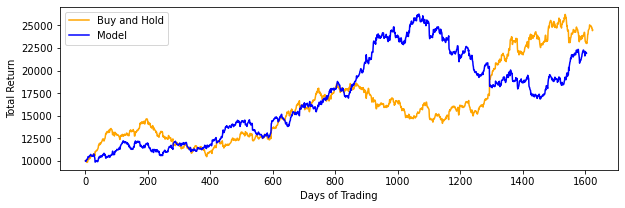

In [40]:
plt.figure(figsize=(10, 3))
plt.plot(buyhold_returns, color='orange', label='Buy and Hold')
plt.plot(active_returns, color='blue', label='Model')
plt.xlabel('Days of Trading')
plt.ylabel('Total Return')
plt.legend()
plt.show()